# Experiments for paper 8811

In [1]:
from time import time
t0 = time()

from functools import partial
from multiprocessing import Pool
import pickle

import numpy as np

from sknetwork.data import load_netset, block_model
from sknetwork.ranking import Dirichlet
from sknetwork.utils import bipartite2undirected
from sknetwork.utils.check import check_labels, check_n_jobs

from sklearn.metrics import f1_score

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('text', usetex=True)
%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
COLORS = prop_cycle.by_key()['color']

## Algorithms

In [3]:
def temperatures(A, seeds, n_jobs=-1, n_iter=10):
    n_jobs = check_n_jobs(n_jobs)
    dirichlet = Dirichlet()
    
    classes = np.unique(seeds[seeds>=0])
    seeds_ova = []
    for c in classes:
        seeds_binary = -np.ones_like(seeds)
        seeds_binary[(seeds >= 0)] = 0.
        seeds_binary[(seeds == c)] = 1.
        seeds_ova.append(seeds_binary)
        
    local_function = partial(dirichlet.fit_transform, A)
    with Pool(n_jobs) as pool:
        T = np.array(pool.map(local_function, seeds_ova)).T
        
    return T

In [4]:
def vanilla(T):
    return T.argmax(axis=1)

In [5]:
def weighted(T, seeds):
    scores = T.copy()
    classes, counts = np.unique(seeds[seeds >= 0], return_counts=True)
    ix = np.argwhere(seeds <= 0).ravel()
    for i, c in enumerate(classes):
        scores[ix, i] *= counts[i] / scores[ix, i].sum()
    return scores.argmax(axis=1)

In [6]:
def centered(T):
    return (T - T.mean(axis=0)).argmax(axis=1)

## Seed sampling

In [7]:
def node_sampling(labels, frac = 0.01):
    n = len(labels)
    n_seeds = int(n * frac)
    labels_seeds = -np.ones(n)
    seeds = np.random.choice(n, n_seeds, replace=False)
    labels_seeds[seeds] = labels[seeds]
    
    return labels_seeds

In [8]:
def edge_sampling(adjacency, labels, frac = 0.01):
    n = len(labels)
    n_seeds = int(n * frac)
    labels_seeds = -np.ones(n)
    probas = adjacency.dot(np.ones(n))
    probas /= probas.sum()
    seeds = np.random.choice(n, n_seeds, replace=False, p=probas)
    labels_seeds[seeds] = labels[seeds]
    
    return labels_seeds

In [9]:
def balanced_sampling(labels, frac = 0.01):
    classes, counts = np.unique(labels, return_counts=True)
    labels_seeds = -np.ones_like(labels)
    
    for i, c in enumerate(classes):
        n_seeds = int(frac * counts[i])
        ix = np.argwhere(labels == c).ravel()
        seeds = np.random.choice(ix, n_seeds, replace=False)
        labels_seeds[seeds] = c
    return labels_seeds

In [10]:
def topclass_sampling(labels, frac = 0.01):
    classes, counts = np.unique(labels, return_counts=True)
    topclass, topcount = classes[counts.argmax()], counts.max()
    index = np.argwhere(labels == topclass).ravel()
    
    n_seeds = int(topcount * frac)
    labels_seeds = -np.ones_like(labels)
    seeds = np.random.choice(index.size, n_seeds, replace=False)
    labels_seeds[index[seeds]] = topclass
    
    return labels_seeds

## Datasets

The datasets are automatically downloaded from https://graphs.telecom-paristech.fr/Home_page.html.

In [11]:
cora = load_netset('cora')
citeseer = load_netset('citeseer')
wikischools = load_netset('wikischools')
wikivitals = load_netset('wikivitals')

In [12]:
cora.meta = {'name': 'cora'}
citeseer.meta = {'name': 'citeseer'}

In [13]:
wikischools.adjacency = bipartite2undirected(wikischools.adjacency)
wikischools.labels = np.concatenate((wikischools.labels, wikischools.labels))
wikivitals.adjacency = bipartite2undirected(wikivitals.adjacency)
wikivitals.labels = np.concatenate((wikivitals.labels, wikivitals.labels))

In [14]:
datasets = [cora, citeseer, wikischools, wikivitals]

## Scores

In [15]:
def benchmark(dataset, seeds_set):
    ns = len(seeds_set)
    scores = {'Vanilla': np.zeros(ns),
              'Weighted': np.zeros(ns),
              'Centered': np.zeros(ns)}
    for i, seeds in enumerate(seeds_set):
        T = temperatures(dataset.adjacency, seeds)
        labels_v = vanilla(T)
        labels_w = weighted(T, seeds)
        labels_c = centered(T)
        
        scores['Vanilla'][i] = f1_score(labels_v, dataset.labels, average='macro')
        scores['Weighted'][i] = f1_score(labels_w, dataset.labels, average='macro')
        scores['Centered'][i] = f1_score(labels_c, dataset.labels, average='macro')
    return scores

In [16]:
def display(scores):
    μ = scores.mean()
    σ = scores.std()
    return '{:.2f} pm {:.2f}'.format(μ, σ)

### Algorithms

In [17]:
colors = {'Vanilla': COLORS[1], 'Weighted': COLORS[2], 'Centered': COLORS[0]}

## Stochastic Block Model (binary classification)

#### Seed asymmetry

In [18]:
n_runs = 10
x = np.arange(10)

In [19]:
scores = {algo: np.zeros((n_runs, len(x))) for algo in colors.keys()}

np.random.seed(0)
for i in range(n_runs):
    frac_ref = 0.1
    n = 10000
    n1 = int(0.5 * n)
    n2 = int(0.5 * n)
    dataset = block_model([n1, n2], metadata=True, p_in=10/n, p_out=1/n)
    seeds_ref = node_sampling(dataset.labels, frac=frac_ref)
    index = np.argwhere(seeds_ref >= 0).ravel()
    
    for j, ratio in enumerate(x):
        seeds = topclass_sampling(dataset.labels, frac=ratio*frac_ref)
        seeds[index] = seeds_ref[index]
        
        scores_run = benchmark(dataset, [seeds])
        for key in colors.keys():
            scores[key][i, j] = scores_run[key]
                         
for name, score in scores.items():
    μ, σ = score.mean(axis=0), score.std(axis=0)
    scores[name] = (μ, σ)

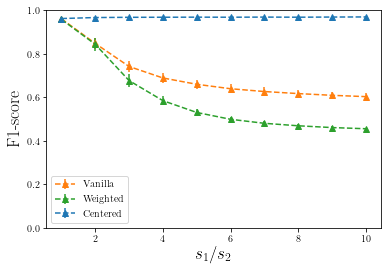

In [20]:
plt.figure()

for algo, (μ, σ) in scores.items():
    plt.errorbar((1+x).astype(int), μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])

plt.ylim(0, 1.)
plt.xlabel(r'$s_1/s_2$', fontsize='xx-large')
plt.ylabel(r'F1-score', fontsize='xx-large')
plt.legend()
plt.savefig('SBM1.pdf', format='pdf')
plt.show()

In [21]:
scores = {algo: np.zeros((n_runs, len(x))) for algo in colors.keys()}

np.random.seed(0)
for i in range(n_runs):
    frac_ref = 0.1
    n_ref = 1000
    block_sizes = n_ref * np.ones(10, dtype=int)
    n = block_sizes.sum()
    
    dataset = block_model(block_sizes, metadata=True, p_in=50/n, p_out=1/n)
    seeds_ref = balanced_sampling(dataset.labels, frac=frac_ref)
    index = np.argwhere(seeds_ref >= 0).ravel()
    
    for j, ratio in enumerate(x):
        seeds = topclass_sampling(dataset.labels, frac=ratio*frac_ref)
        seeds[index] = seeds_ref[index]
        
        scores_run = benchmark(dataset, [seeds])
        for key in colors.keys():
            scores[key][i, j] = scores_run[key]
                         
for name, score in scores.items():
    μ, σ = score.mean(axis=0), score.std(axis=0)
    scores[name] = (μ, σ)

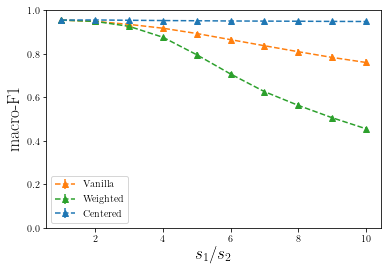

In [22]:
plt.figure()

for algo, (μ, σ) in scores.items():
    plt.errorbar((1+x).astype(int), μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])

plt.ylim(0, 1.)
plt.xlabel(r'$s_1/s_2$', fontsize='xx-large')
plt.ylabel(r'macro-F1', fontsize='xx-large')
plt.legend()
plt.savefig('SBM1_bis.pdf', format='pdf')
plt.show()

#### Block size asymmetry

In [23]:
n_runs = 10
x = np.arange(1, 11)

In [24]:
scores = {algo: np.zeros((n_runs, len(x))) for algo in colors.keys()}

np.random.seed(0)
for j, frac in enumerate(x):
    n = 10000
    n2 = int(n / (1 + frac))
    n1 = n - n2
    dataset = block_model([n1, n2], metadata=True, p_in=10/n, p_out=1/n)
    seed_set = []
    
    seed_set = [balanced_sampling(dataset.labels, frac=0.1) for i in range(n_runs)]
    scores_run = benchmark(dataset, seed_set)
    for key in colors.keys():
        scores[key][:, j] = scores_run[key]
                
for name, score in scores.items():
    μ, σ = score.mean(axis=0), score.std(axis=0)
    scores[name] = (μ, σ)

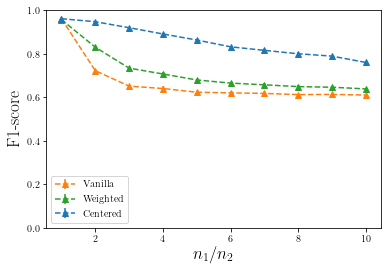

In [25]:
plt.figure()
for algo, (μ, σ) in scores.items():
    plt.errorbar(x, μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])

plt.ylim(0, 1.)
plt.xlabel(r'$n_1/n_2$', fontsize='xx-large')
plt.ylabel(r'F1-score', fontsize='xx-large')
plt.legend()
plt.savefig('SBM2.pdf', format='pdf')
plt.show()

In [26]:
scores = {algo: np.zeros((n_runs, len(x))) for algo in colors.keys()}

np.random.seed(0)
for j, frac in enumerate(x):
    block_sizes = 1000 * np.ones(10, dtype=int)
    block_sizes[0] += 1000 * frac
    n = block_sizes.sum()
    
    dataset = block_model(block_sizes, metadata=True, p_in=50/n, p_out=1/n)
    seed_set = []
    
    seed_set = [balanced_sampling(dataset.labels, frac=0.1) for i in range(n_runs)]
    scores_run = benchmark(dataset, seed_set)
    for key in colors.keys():
        scores[key][:, j] = scores_run[key]
                
for name, score in scores.items():
    μ, σ = score.mean(axis=0), score.std(axis=0)
    scores[name] = (μ, σ)

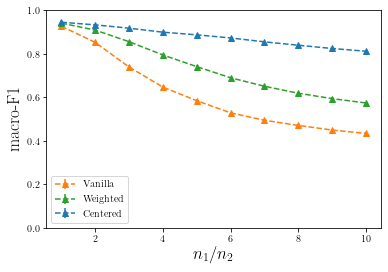

In [27]:
plt.figure()
for algo, (μ, σ) in scores.items():
    plt.errorbar(x, μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])

plt.ylim(0, 1.)
plt.xlabel(r'$n_1/n_2$', fontsize='xx-large')
plt.ylabel(r'macro-F1', fontsize='xx-large')
plt.legend()
plt.savefig('SBM2_bis.pdf', format='pdf')
plt.show()

## Real data (multi-label classification)

In [28]:
n_runs = 10

#### Uniform sampling

In [29]:
np.random.seed(0)
seeds_ns = {dataset.meta['name']: [node_sampling(dataset.labels) for i in range(n_runs)] for dataset in datasets}

In [30]:
for dataset in datasets:
    name = dataset.meta['name']
    print(name)
    seeds = seeds_ns[name]

    scores = benchmark(dataset, seeds)
    for key, value in scores.items():
        print(key + ': ' + display(value))
    print()

cora
Vanilla: 0.19 pm 0.12
Weighted: 0.19 pm 0.12
Centered: 0.42 pm 0.18

citeseer
Vanilla: 0.17 pm 0.04
Weighted: 0.17 pm 0.04
Centered: 0.36 pm 0.04

wikischools
Vanilla: 0.04 pm 0.02
Weighted: 0.04 pm 0.02
Centered: 0.21 pm 0.14

wikivitals
Vanilla: 0.09 pm 0.04
Weighted: 0.08 pm 0.03
Centered: 0.55 pm 0.03



#### Degree sampling

In [31]:
np.random.seed(0)
seeds_es = {dataset.meta['name']: [edge_sampling(dataset.adjacency, dataset.labels) for i in range(n_runs)] for dataset in datasets}

In [32]:
for dataset in datasets:
    name = dataset.meta['name']
    print(name)
    seeds = seeds_es[name]

    scores = benchmark(dataset, seeds)
    for key, value in scores.items():
        print(key + ': ' + display(value))
    print()

cora
Vanilla: 0.30 pm 0.08
Weighted: 0.29 pm 0.08
Centered: 0.51 pm 0.08

citeseer
Vanilla: 0.16 pm 0.07
Weighted: 0.17 pm 0.07
Centered: 0.26 pm 0.13

wikischools
Vanilla: 0.01 pm 0.01
Weighted: 0.02 pm 0.01
Centered: 0.07 pm 0.05

wikivitals
Vanilla: 0.10 pm 0.04
Weighted: 0.12 pm 0.05
Centered: 0.48 pm 0.02



## Biased sampling

In [33]:
s = np.linspace(0.01, 0.09, 9)
n_runs = 10

In [34]:
seeds_biased = {}
np.random.seed(0)
for dataset in datasets:
    seeds_dataset = {}
    for i in range(n_runs):
        ref = node_sampling(dataset.labels)
        index = np.argwhere(ref >= 0).ravel()
        seeds_list = [ref]

        for frac in s:
            seeds = topclass_sampling(dataset.labels, frac=frac)
            seeds[index] = ref[index]
            seeds_list.append(seeds)
        seeds_dataset[i] = seeds_list
    seeds_biased[dataset.meta['name']] = seeds_dataset

In [35]:
def benchmark_biased(dataset, seeds_set):
    shape = (len(seeds_set), len(s)+1)
    scores = {'Vanilla': np.zeros(shape), 'Weighted': np.zeros(shape), 'Centered': np.zeros(shape)}
    
    for i, seeds_list in seeds_set.items():
        scores_run = benchmark(dataset, seeds_list)
        scores['Vanilla'][i, :] = scores_run['Vanilla']
        scores['Weighted'][i, :] = scores_run['Weighted']
        scores['Centered'][i, :] = scores_run['Centered']

    scores['Vanilla'] =  scores['Vanilla'].mean(axis=0), scores['Vanilla'].std(axis=0)
    scores['Weighted'] =  scores['Weighted'].mean(axis=0), scores['Weighted'].std(axis=0)
    scores['Centered'] =  scores['Centered'].mean(axis=0), scores['Centered'].std(axis=0)
    
    return scores

In [36]:
scores_biased = {dataset.meta['name']: {} for dataset in datasets}

for dataset in datasets:
    name = dataset.meta['name']
    seeds = seeds_biased[name]
    scores_biased[name] = benchmark_biased(dataset, seeds)

In [37]:
pickle.dump(scores_biased, open('scores_biased.p', 'wb'))

In [38]:
scores_biased = pickle.load(open('scores_biased.p', 'rb'))

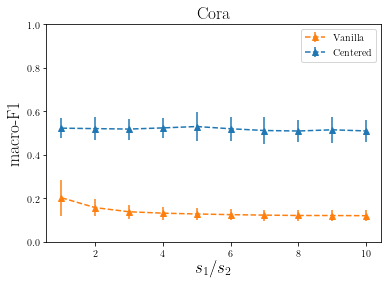

In [39]:
name = 'cora'
plt.figure()
x = np.arange(1, 11)
for algo, (μ, σ) in scores_biased[name].items():
    if algo != 'Weighted':
        plt.errorbar(x, μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])

plt.title(r'Cora', fontsize='xx-large')
plt.ylim(0, 1.)
plt.xlabel(r'$s_1/s_2$', fontsize='xx-large')
plt.ylabel(r'macro-F1', fontsize='xx-large')
plt.legend()
plt.savefig(name+'.pdf', format='pdf')
plt.show()

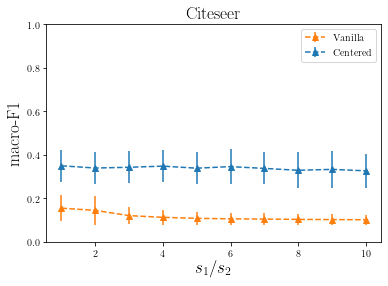

In [40]:
name = 'citeseer'
plt.figure()
x = np.arange(1, 11)
for algo, (μ, σ) in scores_biased[name].items():
    if algo != 'Weighted':
        plt.errorbar(x, μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])


plt.title(r'Citeseer', fontsize='xx-large')
plt.ylim(0, 1.)
plt.xlabel(r'$s_1/s_2$', fontsize='xx-large')
plt.ylabel(r'macro-F1', fontsize='xx-large')
plt.legend()
plt.savefig(name+'.pdf', format='pdf')
plt.show()

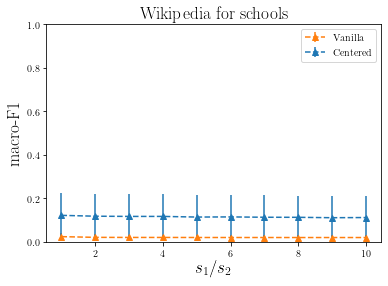

In [41]:
name = 'wikischools'
plt.figure()
x = np.arange(1, 11)
for algo, (μ, σ) in scores_biased[name].items():
    if algo != 'Weighted':
        plt.errorbar(x, μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])


plt.title(r'Wikipedia\ for\ schools', fontsize='xx-large')
plt.ylim(0, 1.)
plt.xlabel(r'$s_1/s_2$', fontsize='xx-large')
plt.ylabel(r'macro-F1', fontsize='xx-large')
plt.legend()
plt.savefig(name+'.pdf', format='pdf')
plt.show()

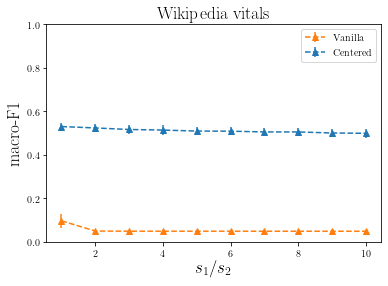

In [42]:
name = 'wikivitals'
plt.figure()
x = np.arange(1, 11)
for algo, (μ, σ) in scores_biased[name].items():
    if algo != 'Weighted':
        plt.errorbar(x, μ, σ, linestyle='--', marker='^', label=algo, c=colors[algo])


plt.title(r'Wikipedia\ vitals', fontsize='xx-large')
plt.ylim(0, 1.)
plt.xlabel(r'$s_1/s_2$', fontsize='xx-large')
plt.ylabel(r'macro-F1', fontsize='xx-large')
plt.legend()
plt.savefig(name+'.pdf', format='pdf')
plt.show()

In [43]:
total_runtime = time() - t0
print(total_runtime / 60)

5.623368767897288
